# Capacity allocation

In [2]:
!python3 -m pip install -e /home/oreto2024/PycharmProjects/robin

Obtaining file:///home/oreto2024/PycharmProjects/robin
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for robin (pyproject.toml) ... done
  Created wheel for robin: filename=robin-0.0.post1.dev693+g09e8b4e-0.editable-py3-none-any.whl size=4671 sha256=a712e887bbdff0e7e9c63789f3f917da7d67d158678c4afc64ae2f88bccc53f5
  Stored in directory: /tmp/pip-ephem-wheel-cache-4075o6oz/wheels/c6/48/3a/80585332bc876223c19a86be895920efe423de99b02bf42862
Successfully built robin


## 0. Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from benchmarks.generator import get_revenue_behavior, get_revenue_behavior_deprecated
from benchmarks.robin_railway import RevenueMaximization
from benchmarks.utils import sns_box_plot, sns_line_plot, int_input, get_schedule_from_supply, infer_line_stations, get_services_by_tsp_df, plot_marey_chart
from src.entities import GSA, Solution
from src.timetabling_problem import MPTT

from robin.scraping.entities import SupplySaver
from robin.services_generator.entities import ServiceGenerator
from robin.supply.entities import Service, Supply

from mealpy.evolutionary_based import GA
from mealpy import IntegerVar
from pathlib import Path
import shutil
from typing import Any, List, Mapping, Tuple, Union

In [2]:
# Config files
supply_config_path = Path("../configs/generator/supply_config.yml")
demand_config_path = Path("../configs/demand/demand.yml")
generator_config_path = Path("../configs/generator/generator_config.yml")

# Save paths
generator_save_path = Path(f'../data/generator/supply_dummy.yml')
supply_save_path = '../configs/mealpy/'
robin_save_path = '../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(generator_save_path.parent).exists():
    shutil.rmtree(generator_save_path.parent)

Path(generator_save_path.parent).mkdir(parents=True)

if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)
    
Path(supply_save_path).mkdir(parents=True)

#if Path(figures).exists():
#    shutil.rmtree(figures)
#Path(figures).mkdir(parents=True)

In [3]:
frame_capacity = {'1': 0.2, '2': 0.2, '3': 0.2, '4': 0.2, '5': 0.2}

n_services = 50
n_services_by_ru = {ru: round(cap * n_services) for ru, cap in frame_capacity.items()}

n_services_by_ru

{'1': 10, '2': 10, '3': 10, '4': 10, '5': 10}

In [4]:
seed = 21

if generator_config_path:
    generator = ServiceGenerator(supply_config_path=supply_config_path)
    _ = generator.generate(file_name=generator_save_path,
                           path_config=generator_config_path,
                           n_services_by_ru=n_services_by_ru,
                           seed=seed)
    print(f'Number of service requests generated: {len(_)}')

Number of service requests generated: 50


In [5]:
supply = Supply.from_yaml(generator_save_path)
tsp_df = get_services_by_tsp_df(supply.services)
print(tsp_df)

     Number of Services
RU1                  10
RU2                  10
RU3                  10
RU4                  10
RU5                  10


In [6]:
print("Services: ", len(supply.services))
requested_schedule = get_schedule_from_supply(generator_save_path)
revenue_behavior = get_revenue_behavior_deprecated(supply)
lines = supply.lines
line = infer_line_stations(lines)

Services:  50


In [7]:
n_services = sum(tsp_df["Number of Services"].values)

services_by_ru = {}
for service in revenue_behavior:
    if revenue_behavior[service]['ru'] not in services_by_ru:
        services_by_ru[revenue_behavior[service]['ru']] = 1
    else:
        services_by_ru[revenue_behavior[service]['ru']] += 1

services_by_ru = {f"RU{k}": v for k, v in services_by_ru.items()}
print(services_by_ru)

frame_capacity = {ru: round(services_by_ru[ru] / n_services * 100, 2) for ru in services_by_ru}
print(frame_capacity)

{'RU1': 10, 'RU2': 10, 'RU3': 10, 'RU4': 10, 'RU5': 10}
{'RU1': 20.0, 'RU2': 20.0, 'RU3': 20.0, 'RU4': 20.0, 'RU5': 20.0}


/Users/david/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


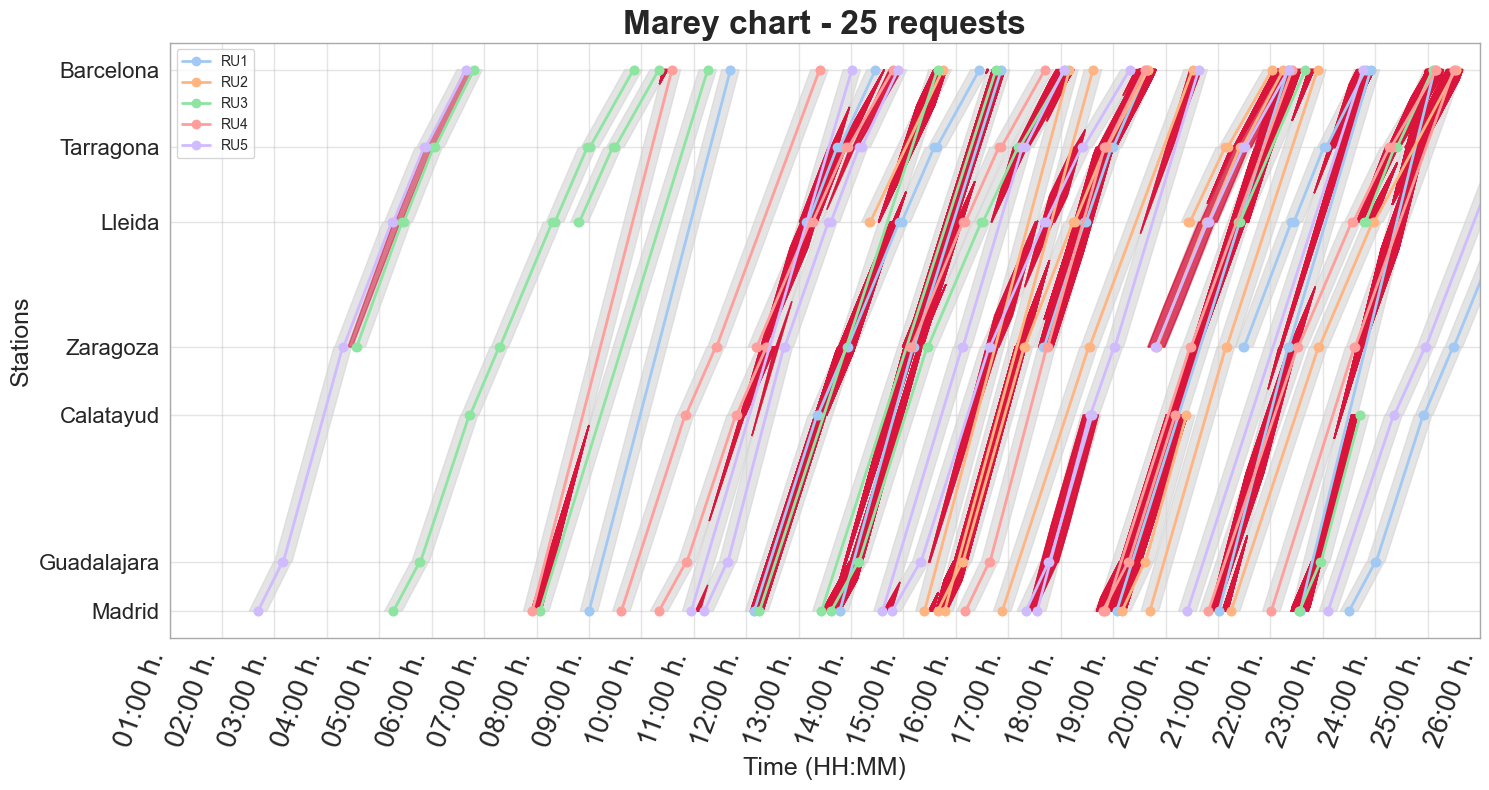

In [8]:
plot_marey_chart(requested_supply=supply,
                 colors_by_tsp=True, 
                 main_title="Marey chart - 25 requests",
                 plot_security_gaps=True,
                 security_gap=10,
                 save_path=Path('../reports/mealpy/marey_chart_requests_25.pdf'))

## 1. Mealpy

In [9]:
alpha_values = {"Revenue": 1, "Jain": 25, "Gini": 10, "Atkinson": 25}

## 2. Results analysis

In [26]:
reports_path = Path('../reports/mealpy/')

In [27]:
file_name = "opti_alpha_balanced"

In [28]:
df_history = pd.read_csv(reports_path / f'df_history_equity_{file_name}.csv', sep=";")
df_population = pd.read_csv(reports_path / f'df_population_equity_{file_name}.csv', sep=";")

In [29]:
df_history

,Run,FairIndex,Iteration,Fitness,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration
0,1,Revenue,0,2461.973756,1.043520,[ True True False True False False False Tr...,[1060. 1110. 1147. 1388. 1441. 1499. 1536. 159...,11.948462,0.000000,100.000000
1,1,Revenue,1,2848.061691,1.012306,[False True True True False False False Tr...,[1074. 1114. 1147. 1467. 1443. 1500. 1536. 159...,10.636615,10.979206,89.020794
2,1,Revenue,2,3085.956975,0.982023,[False True False True False False False Tr...,[1001. 1110. 1146. 1388. 1441. 1502. 1530. 159...,9.710154,18.733020,81.266980
3,1,Revenue,3,3317.718809,0.982299,[ True True False True False False False Tr...,[1060. 1114. 1146. 1379. 1441. 1496. 1530. 159...,8.878462,25.693684,74.306316
4,1,Revenue,4,3377.100533,1.003383,[False True False True False False False Tr...,[1001. 1110. 1146. 1379. 1441. 1496. 1530. 159...,7.886769,33.993433,66.006567
...,...,...,...,...,...,...,...,...,...,...
1995,5,Atkinson,95,4001.470520,1.050625,[False True True False False False True Fal...,[1008. 1113. 1143. 1397. 1442. 1498. 1535. 159...,2.804923,76.801415,23.198585
1996,5,Atkinson,96,4001.470520,1.055216,[False True True False False False True Fal...,[1008. 1113. 1143. 1397. 1442. 1498. 1535. 159...,3.222308,73.349366,26.650634
1997,5,Atkinson,97,4001.470520,1.046858,[False True True False False False True Fal...,[1008. 1113. 1143. 1397. 1442. 1498. 1535. 159...,3.309231,72.630454,27.369546
1998,5,Atkinson,98,4001.470520,1.051797,[False True True False False False True Fal...,[1008. 1113. 1143. 1397. 1442. 1498. 1535. 159...,2.978769,75.363591,24.636409


In [30]:
df_population

,Run,FairIndex,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,...,discrete_40,discrete_41,discrete_42,discrete_43,discrete_44,discrete_45,discrete_46,discrete_47,discrete_48,discrete_49
0,1,Revenue,0,[1015. 1112. 1145. 1418. 1450. 1503. 1531. 159...,[1060. 1116. 1147. 1379. 1443. 1496. 1535. 159...,[1094. 1113. 1145. 1440. 1447. 1502. 1530. 159...,[1074. 1114. 1142. 1467. 1444. 1500. 1539. 159...,[1090. 1113. 1143. 1396. 1444. 1499. 1532. 159...,[1001. 1116. 1148. 1388. 1441. 1505. 1536. 159...,[1094. 1116. 1145. 1379. 1447. 1502. 1531. 159...,...,[False True False False False False False Tr...,[False True False True False False False Tr...,[False True True False False False False Fal...,[False True False False False False False Fal...,[False True False False False False False Tr...,[False True False False False False False Fal...,[False True False False False False False Fal...,[False True True True False False False Tr...,[ True True False False False False False Tr...,[False True False False False False False Fal...
1,1,Revenue,1,[1094. 1114. 1146. 1456. 1444. 1499. 1530. 159...,[1074. 1113. 1145. 1440. 1447. 1502. 1539. 159...,[1015. 1113. 1145. 1440. 1443. 1502. 1530. 159...,[1094. 1113. 1146. 1440. 1447. 1496. 1530. 159...,[1040. 1116. 1143. 1440. 1444. 1499. 1539. 159...,[1069. 1113. 1145. 1467. 1447. 1502. 1530. 159...,[1060. 1110. 1146. 1440. 1443. 1499. 1530. 159...,...,[False True False False False False False Tr...,[ True True False True False False False Tr...,[ True True False False False False False Tr...,[False True True False False False False Fal...,[ True True True False False False False Tr...,[False True False True False False False Fal...,[False True True True False False False Tr...,[False True False False False False False Fal...,[ True True False False False False False Tr...,[False True True False False False False Fal...
2,1,Revenue,2,[1060. 1110. 1143. 1379. 1447. 1499. 1536. 159...,[1060. 1116. 1147. 1388. 1441. 1499. 1536. 159...,[1001. 1114. 1146. 1388. 1441. 1502. 1536. 159...,[1060. 1110. 1146. 1440. 1441. 1499. 1539. 159...,[1040. 1116. 1143. 1440. 1444. 1499. 1539. 159...,[1060. 1110. 1147. 1418. 1441. 1499. 1539. 159...,[1074. 1114. 1141. 1468. 1444. 1500. 1539. 159...,...,[False True False False False False False Tr...,[ True True False True False False False Tr...,[False True False False False False False Tr...,[False True False True False False False Tr...,[False True False True False False False Tr...,[False True True True False False False Tr...,[False True False True False False False Tr...,[False True False True False False False Tr...,[False True False False False False False Fal...,[False True False False False False False Tr...
3,1,Revenue,3,[1060. 1110. 1147. 1388. 1450. 1499. 1536. 159...,[1074. 1114. 1147. 1440. 1443. 1499. 1536. 159...,[1001. 1110. 1147. 1418. 1441. 1499. 1536. 159...,[1060. 1114. 1147. 1440. 1441. 1502. 1539. 159...,[1060. 1116. 1147. 1379. 1447. 1496. 1535. 159...,[1001. 1110. 1146. 1388. 1441. 1502. 1530. 159...,[1001. 1110. 1146. 1388. 1441. 1502. 1530. 159...,...,[False True False True False False False Fal...,[False True True False False False False Tr...,[False True False False False False False Tr...,[ True True False True False False False Tr...,[False True False True False False False Tr...,[False True True False False False False Tr...,[ True True False False False False False Tr...,[False True False True True False False Tr...,[ True True True False False False False Tr...,[False True False True False False False Fal...
4,1,Revenue,4,[1001. 1110. 1146. 1417. 1441. 1502. 1530. 159...,[1060. 1116. 1147. 1379. 1441. 1499. 1536. 159...,[1060. 1116. 1147. 1379. 1441. 1499. 1530. 159...,[1060. 1110. 1146. 1388. 1441. 1499. 1536. 159...,[1060. 1116. 1146. 1423. 1443. 1499. 1530. 159...,[1074. 1110. 1147. 1440. 1450. 1503. 1536. 159...,[1060. 1116. 1147. 1440. 1441. 1499. 1536. 159...,...,[False True False False False False False Tr...,[ True Tr

In [31]:
columns_to_transform = df_population.filter(like="real_").columns

df_population[columns_to_transform] = df_population[columns_to_transform].apply(
    lambda col: col.map(lambda x: list(map(float, x[1:-1].split())))
)

df_population.head()

,Run,FairIndex,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,...,discrete_40,discrete_41,discrete_42,discrete_43,discrete_44,discrete_45,discrete_46,discrete_47,discrete_48,discrete_49
0,1,Revenue,0,"[1015.0, 1112.0, 1145.0, 1418.0, 1450.0, 1503....","[1060.0, 1116.0, 1147.0, 1379.0, 1443.0, 1496....","[1094.0, 1113.0, 1145.0, 1440.0, 1447.0, 1502....","[1074.0, 1114.0, 1142.0, 1467.0, 1444.0, 1500....","[1090.0, 1113.0, 1143.0, 1396.0, 1444.0, 1499....","[1001.0, 1116.0, 1148.0, 1388.0, 1441.0, 1505....","[1094.0, 1116.0, 1145.0, 1379.0, 1447.0, 1502....",...,[False True False False False False False Tr...,[False True False True False False False Tr...,[False True True False False False False Fal...,[False True False False False False False Fal...,[False True False False False False False Tr...,[False True False False False False False Fal...,[False True False False False False False Fal...,[False True True True False False False Tr...,[ True True False False False False False Tr...,[False True False False False False False Fal...
1,1,Revenue,1,"[1094.0, 1114.0, 1146.0, 1456.0, 1444.0, 1499....","[1074.0, 1113.0, 1145.0, 1440.0, 1447.0, 1502....","[1015.0, 1113.0, 1145.0, 1440.0, 1443.0, 1502....","[1094.0, 1113.0, 1146.0, 1440.0, 1447.0, 1496....","[1040.0, 1116.0, 1143.0, 1440.0, 1444.0, 1499....","[1069.0, 1113.0, 1145.0, 1467.0, 1447.0, 1502....","[1060.0, 1110.0, 1146.0, 1440.0, 1443.0, 1499....",...,[False True False False False False False Tr...,[ True True False True False False False Tr...,[ True True False False False False False Tr...,[False True True False False False False Fal...,[ True True True False False False False Tr...,[False True False True False False False Fal...,[False True True True False False False Tr...,[False True False False False False False Fal...,[ True True False False False False False Tr...,[False True True False False False False Fal...
2,1,Revenue,2,"[1060.0, 1110.0, 1143.0, 1379.0, 1447.0, 1499....","[1060.0, 1116.0, 1147.0, 1388.0, 1441.0, 1499....","[1001.0, 1114.0, 1146.0, 1388.0, 1441.0, 1502....","[1060.0, 1110.0, 1146.0, 1440.0, 1441.0, 1499....","[1040.0, 1116.0, 1143.0, 1440.0, 1444.0, 1499....","[1060.0, 1110.0, 1147.0, 1418.0, 1441.0, 1499....","[1074.0, 1114.0, 1141.0, 1468.0, 1444.0, 1500....",...,[False True False False False False False Tr...,[ True True False True False False False Tr...,[False True False False False False False Tr...,[False True False True False False False Tr...,[False True False True False False False Tr...,[False True True True False False False Tr...,[False True False True False False False Tr...,[False True False True False False False Tr...,[False True False False False False False Fal...,[False True False False False False False Tr...
3,1,Revenue,3,"[1060.0, 1110.0, 1147.0, 1388.0, 1450.0, 1499....","[1074.0, 1114.0, 1147.0, 1440.0, 1443.0, 1499....","[1001.0, 1110.0, 1147.0, 1418.0, 1441.0, 1499....","[1060.0, 1114.0, 1147.0, 1440.0, 1441.0, 1502....","[1060.0, 1116.0, 1147.0, 1379.0, 1447.0, 1496....","[1001.0, 1110.0, 1146.0, 1388.0, 1441.0, 1502....","[1001.0, 1110.0, 1146.0, 1388.0, 1441.0, 1502....",...,[False True False True False False False Fal...,[False True True False False False False Tr...,[False True False False False False False Tr...,[ True True False True False False False Tr...,[False True False True False False False Tr...,[False True True False False False False Tr...,[ True True False False False False False Tr...,[False True False True True False False Tr...,[ True True True False False False False Tr...,[False True False True False False False Fal...
4,1,Revenue,4,"[1001.0, 1110.0, 1146.0, 1417.0, 1441.0, 1502....","[1060.0, 1116.0, 1147.0, 1379.0, 1441.0, 1499....","[1060.0, 1116.0, 1147.0, 1379.0, 1441.0, 1499....","[1060.0, 1110.0, 1146.0, 1388.0, 1441.0, 1499....","[1060.0, 1116.0, 1146.0, 1423.0, 1443.0, 1499....","[1074.0, 1110.0, 1147.0, 1440.0, 1450.0, 1503....","[1060.0, 1116.0, 1147.0, 1440.0, 1441.0, 1

In [32]:
columns_to_transform = df_population.filter(like="discrete_").columns

df_population[columns_to_transform] = df_population[columns_to_transform].apply(
    lambda col: col.map(lambda x: list(map(lambda x: 1 if x == "True" else 0, x[1:-1].split())))
)

df_population.head()

,Run,FairIndex,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,...,discrete_40,discrete_41,discrete_42,discrete_43,discrete_44,discrete_45,discrete_46,discrete_47,discrete_48,discrete_49
0,1,Revenue,0,"[1015.0, 1112.0, 1145.0, 1418.0, 1450.0, 1503....","[1060.0, 1116.0, 1147.0, 1379.0, 1443.0, 1496....","[1094.0, 1113.0, 1145.0, 1440.0, 1447.0, 1502....","[1074.0, 1114.0, 1142.0, 1467.0, 1444.0, 1500....","[1090.0, 1113.0, 1143.0, 1396.0, 1444.0, 1499....","[1001.0, 1116.0, 1148.0, 1388.0, 1441.0, 1505....","[1094.0, 1116.0, 1145.0, 1379.0, 1447.0, 1502....",...,"[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...","[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...","[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...","[0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...","[0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, ..."
1,1,Revenue,1,"[1094.0, 1114.0, 1146.0, 1456.0, 1444.0, 1499....","[1074.0, 1113.0, 1145.0, 1440.0, 1447.0, 1502....","[1015.0, 1113.0, 1145.0, 1440.0, 1443.0, 1502....","[1094.0, 1113.0, 1146.0, 1440.0, 1447.0, 1496....","[1040.0, 1116.0, 1143.0, 1440.0, 1444.0, 1499....","[1069.0, 1113.0, 1145.0, 1467.0, 1447.0, 1502....","[1060.0, 1110.0, 1146.0, 1440.0, 1443.0, 1499....",...,"[0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, ...","[1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, ...","[1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, ...","[0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...","[1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, ...","[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, ...","[0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...","[1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, ...","[0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ..."
2,1,Revenue,2,"[1060.0, 1110.0, 1143.0, 1379.0, 1447.0, 1499....","[1060.0, 1116.0, 1147.0, 1388.0, 1441.0, 1499....","[1001.0, 1114.0, 1146.0, 1388.0, 1441.0, 1502....","[1060.0, 1110.0, 1146.0, 1440.0, 1441.0, 1499....","[1040.0, 1116.0, 1143.0, 1440.0, 1444.0, 1499....","[1060.0, 1110.0, 1147.0, 1418.0, 1441.0, 1499....","[1074.0, 1114.0, 1141.0, 1468.0, 1444.0, 1500....",...,"[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...","[1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, ...","[0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, ...","[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...","[0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, ...","[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...","[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...","[0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ..."
3,1,Revenue,3,"[1060.0, 1110.0, 1147.0, 1388.0, 1450.0, 1499....","[1074.0, 1114.0, 1147.0, 1440.0, 1443.0, 1499....","[1001.0, 1110.0, 1147.0, 1418.0, 1441.0, 1499....","[1060.0, 1114.0, 1147.0, 1440.0, 1441.0, 1502....","[1060.0, 1116.0, 1147.0, 1379.0, 1447.0, 1496....","[1001.0, 1110.0, 1146.0, 1388.0, 1441.0, 1502....","[1001.0, 1110.0, 1146.0, 1388.0, 1441.0, 1502....",...,"[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...","[0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, ...","[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...","[1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...","[0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, ...","[0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, ...","[1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, ...","[0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, ...","[1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, ...","[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ..."
4,1,Revenue,4,"[1001.0, 1110.0, 1146.0, 1417.0, 1441.0, 1502....","[1060.0, 1116.0, 1147.0, 1379.0, 1441.0, 1499....","[1060.0, 1116.0, 1147.0, 1379.0, 1441.0, 1499....","[1060.0, 1110.0, 1146.0

In [33]:
# Transformar columnas con Real y Discrete después de leer el .csv
from src.timetabling_problem import MPTT

# Define new revenue maximization object for results analysis
mptt = MPTT(requested_schedule=requested_schedule,
            revenue_behavior=revenue_behavior,
            line=line,
            safe_headway=10)

columns_to_transform = df_history.filter(like="Real").columns

df_history[columns_to_transform] = df_history[columns_to_transform].apply(
    lambda col: col.map(lambda x: np.array(list(map(float, x[1:-1].split())), dtype=np.int32))
)

columns_to_transform = df_history.filter(like="Discrete").columns

df_history[columns_to_transform] = df_history[columns_to_transform].apply(
    lambda col: col.map(lambda x: np.array(list(map(lambda s: True if s == "True" else False, x[1:-1].split())), dtype=bool))
)

# Incluir columnas con beneficio
df_history['Revenue'] = df_history['Real'].apply(mptt.objective_function)
df_history.head()

,Run,FairIndex,Iteration,Fitness,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration,Revenue
0,1,Revenue,0,2461.973756,1.043520,"[True, True, False, True, False, False, False,...","[1060, 1110, 1147, 1388, 1441, 1499, 1536, 159...",11.948462,0.000000,100.000000,2461.973756
1,1,Revenue,1,2848.061691,1.012306,"[False, True, True, True, False, False, False,...","[1074, 1114, 1147, 1467, 1443, 1500, 1536, 159...",10.636615,10.979206,89.020794,2848.061691
2,1,Revenue,2,3085.956975,0.982023,"[False, True, False, True, False, False, False...","[1001, 1110, 1146, 1388, 1441, 1502, 1530, 159...",9.710154,18.733020,81.266980,3085.956975
3,1,Revenue,3,3317.718809,0.982299,"[True, True, False, True, False, False, False,...","[1060, 1114, 1146, 1379, 1441, 1496, 1530, 159...",8.878462,25.693684,74.306316,3317.718809
4,1,Revenue,4,3377.100533,1.003383,"[False, True, False, True, False, False, False...","[1001, 1110, 1146, 1379, 1441, 1496, 1530, 159...",7.886769,33.993433,66.006567,3377.100533


In [34]:
# Function to compute fitness

# Mapeo de servicios a nombres de RU (por ejemplo, "RU1", "RU2", etc.)
service_tsps = {service.id: service.tsp.name for service in supply.services}
ru_names = sorted(set(service_tsps.values()))

def fitness_from_real(x: np.array) -> float:
    return mptt.objective_function(x)

max_ineq = (len(ru_names)**2) / 4 if len(ru_names) % 2 == 0 else (len(ru_names) // 2) * ((len(ru_names) + 1) // 2)

def pairwise_diff_from_discrete(scheduled_trains_array) -> float:
    # Obtener el diccionario de importancias (por RU) a partir del vector booleano de servicios planificados.
    importance_dict = mptt.sum_importance(scheduled_trains_array)
    importance_dict = {f'RU{k}': v for k, v in importance_dict.items()}

    # Calcular la suma de diferencias absolutas pairwise entre las importancias.
    pairwise_diff = 0
    for ru1, ru2 in itertools.combinations(ru_names, 2):
        pairwise_diff += abs(importance_dict.get(ru1, 0) - importance_dict.get(ru2, 0))

    return round(pairwise_diff / max_ineq * 100, 2)

def jain_index_from_discrete(scheduled, alpha) -> float:
    return mptt.jain_fairness_index(scheduled, mptt.capacities, alpha)[0]

def gini_index_from_discrete(scheduled, alpha) -> float:
    return mptt.gini_fairness_index(scheduled, mptt.capacities, alpha)[0]

def atkinson_index_from_discrete(scheduled, alpha) -> float:
    return mptt.atkinson_fairness_index(scheduled, mptt.capacities, alpha)[0]

In [43]:
import itertools

def get_plot_df(df: pd.DataFrame,
                map_function_selector: str = "Inequity") -> pd.DataFrame:
    filter_fair_index = ("Revenue", "Jain", "Gini", "Atkinson")

    # Create dataframe with fitness values for each individual of the population
    df_pop = df[df['FairIndex'].isin(filter_fair_index)]

    set_filtered_algos = set(df_pop["FairIndex"])
    print(f"Filtered algos: {set_filtered_algos}")

    df_pop = df_pop.replace(r'\n', ' ', regex=True)

    # Iterate through the dataframe and apply the function with progress feedback
    previous_run, previous_algo = None, None

    for index, row in df_pop.iterrows():
        current_run = row['Run']
        current_algo = row['FairIndex']
        real_solution = row

        # Print message if there's a change in 'Run' or 'FairIndex'
        if current_run != previous_run or current_algo != previous_algo:
            print(f"Processing new combination: Run = {current_run}, FairIndex = {current_algo}")
            previous_run, previous_algo = current_run, current_algo

        if map_function_selector == "Inequity":
            map_function = pairwise_diff_from_discrete
        else:
            # Apply the fitness function to the real columns
            if current_algo == "Jain":
                map_function = lambda x: jain_index_from_discrete(x, alpha_values[current_algo])
            elif current_algo == "Gini":
                map_function = lambda x: gini_index_from_discrete(x, alpha_values[current_algo])
            elif current_algo == "Atkinson":
                map_function = lambda x: atkinson_index_from_discrete(x, alpha_values[current_algo])
            else:
                map_function = lambda x: 1

        # Apply the fitness function to the real columns
        df_pop.loc[index, 'Inequity'] = map_function(row['Discrete'])

    print("Processing completed.")

    # Prepare dataframe for boxplot
    rows = []
    for row in df_pop.iterrows():
        run = row[1]['Run']
        iteration = row[1]['Iteration']
        fair_index = row[1]['FairIndex']

        inequity = row[1]['Inequity']
        rows.append({'Run': run, 'Iteration': iteration, 'Inequity': inequity, 'FairIndex': fair_index})

    return pd.DataFrame.from_dict(rows, orient='columns')

Filtered algos: {'Jain', 'Gini', 'Revenue', 'Atkinson'}
Processing new combination: Run = 1, FairIndex = Revenue
Processing new combination: Run = 2, FairIndex = Revenue
Processing new combination: Run = 3, FairIndex = Revenue
Processing new combination: Run = 4, FairIndex = Revenue
Processing new combination: Run = 5, FairIndex = Revenue
Processing new combination: Run = 1, FairIndex = Jain
Processing new combination: Run = 2, FairIndex = Jain
Processing new combination: Run = 3, FairIndex = Jain
Processing new combination: Run = 4, FairIndex = Jain
Processing new combination: Run = 5, FairIndex = Jain
Processing new combination: Run = 1, FairIndex = Gini
Processing new combination: Run = 2, FairIndex = Gini
Processing new combination: Run = 3, FairIndex = Gini
Processing new combination: Run = 4, FairIndex = Gini
Processing new combination: Run = 5, FairIndex = Gini
Processing new combination: Run = 1, FairIndex = Atkinson
Processing new combination: Run = 2, FairIndex = Atkinson
Pro

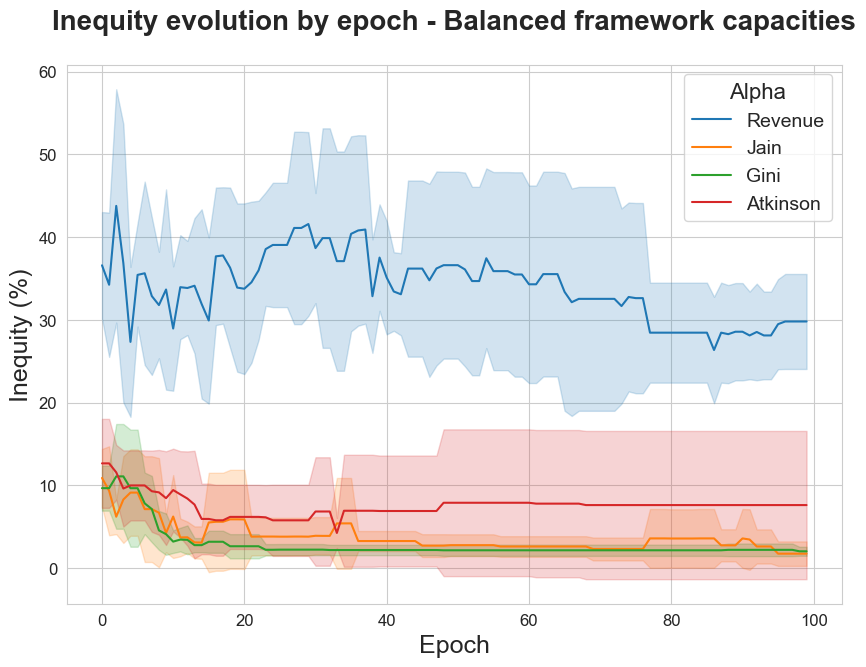

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.lineplot(
    data=get_plot_df(df_history, map_function_selector="Inequity"),
    x="Iteration",
    y="Inequity",
    hue="FairIndex",
    estimator="mean",
    errorbar="sd",  # Standard deviation
    marker=None
)

plt.legend(title="Fair Index")

plt.title("Inequity evolution by epoch - Balanced framework capacities",
          y=1.05,
          fontsize=20,
          fontweight='bold')

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Inequity (%)", fontsize=18)

plt.tick_params(axis='both', labelsize=12)
# Agregar una única leyenda fuera del área de los gráficos
plt.legend(fontsize=14, title="Alpha", title_fontsize=16)

# Guardar el gráfico como PDF
plt.savefig("../reports/mealpy/figures/balanced_pairwise_diff.pdf", format="pdf", bbox_inches="tight")

plt.show()

Filtered algos: {'Gini', 'Jain', 'Atkinson'}
Processing new combination: Run = 1, FairIndex = Jain
Processing new combination: Run = 2, FairIndex = Jain
Processing new combination: Run = 3, FairIndex = Jain
Processing new combination: Run = 4, FairIndex = Jain
Processing new combination: Run = 5, FairIndex = Jain
Processing new combination: Run = 1, FairIndex = Gini
Processing new combination: Run = 2, FairIndex = Gini
Processing new combination: Run = 3, FairIndex = Gini
Processing new combination: Run = 4, FairIndex = Gini
Processing new combination: Run = 5, FairIndex = Gini
Processing new combination: Run = 1, FairIndex = Atkinson
Processing new combination: Run = 2, FairIndex = Atkinson
Processing new combination: Run = 3, FairIndex = Atkinson
Processing new combination: Run = 4, FairIndex = Atkinson
Processing new combination: Run = 5, FairIndex = Atkinson
Processing completed.


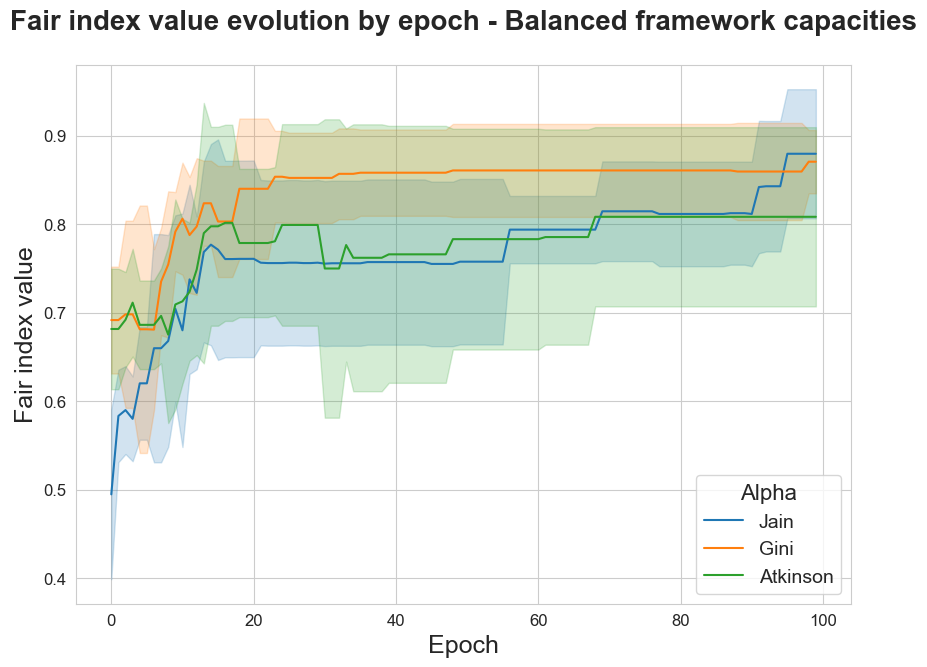

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

df_filtered = df_history[df_history['FairIndex'] != "Revenue"]

sns.lineplot(
    data=get_plot_df(df_filtered, map_function_selector="Revenue"),
    x="Iteration",
    y="Inequity",
    hue="FairIndex",
    estimator="mean",
    errorbar="sd",  # Standard deviation
    marker=None
)

plt.legend(title="Fair Index")

plt.title("Fair index value evolution by epoch - Balanced framework capacities",
          y=1.05,
          fontsize=20,
          fontweight='bold')

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Fair index value", fontsize=18)

plt.tick_params(axis='both', labelsize=12)
# Agregar una única leyenda fuera del área de los gráficos
plt.legend(fontsize=14, title="Alpha", title_fontsize=16, loc="lower right")

# Guardar el gráfico como PDF
plt.savefig("../reports/mealpy/figures/balanced_fair_index_evo.pdf", format="pdf", bbox_inches="tight")

plt.show()

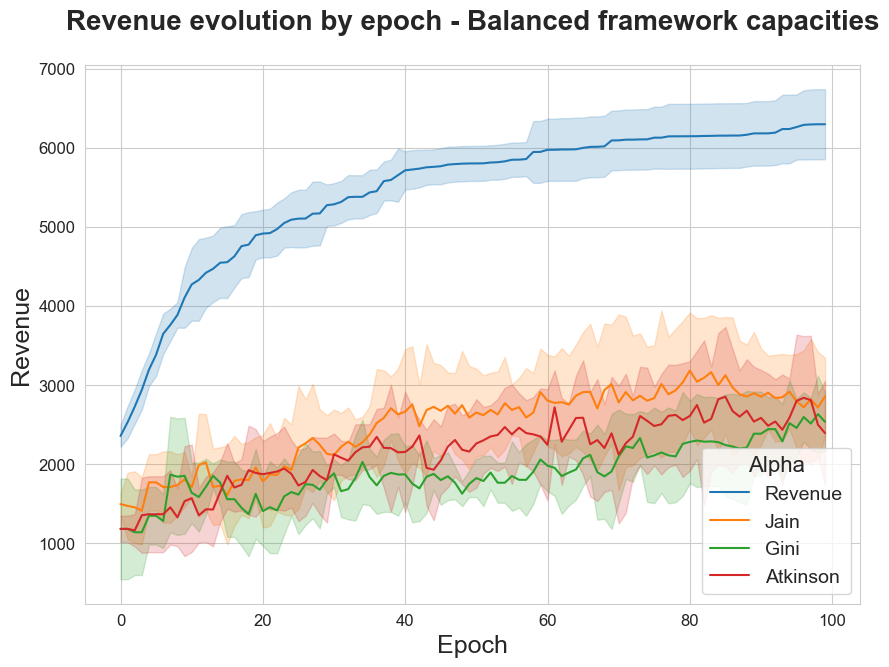

In [56]:
plt.figure(figsize=(10, 7))

# df_filtered = df_history[df_history['FairIndex'] != "Revenue"]

sns.lineplot(
    data=df_history,
    x="Iteration",
    y="Revenue",
    hue="FairIndex",
    estimator="mean",
    errorbar="sd",  # Standard deviation
    marker=None
)

plt.legend(title="Fair Index")

plt.title("Revenue evolution by epoch - Balanced framework capacities",
          y=1.05,
          fontsize=20,
          fontweight='bold')

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Revenue", fontsize=18)

plt.tick_params(axis='both', labelsize=12)
# Agregar una única leyenda fuera del área de los gráficos
plt.legend(fontsize=14, title="Alpha", title_fontsize=16, loc="lower right")

# Guardar el gráfico como PDF
plt.savefig("../reports/mealpy/figures/revenue_balanced_evo.pdf", format="pdf", bbox_inches="tight")

plt.show()

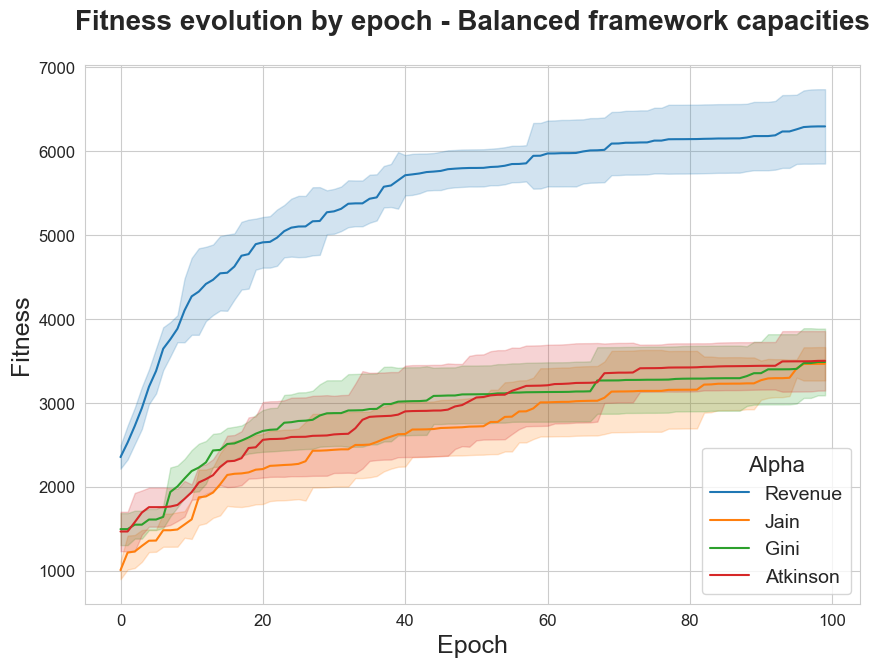

In [57]:
plt.figure(figsize=(10, 7))

# df_filtered = df_history[df_history['FairIndex'] != "Revenue"]

sns.lineplot(
    data=df_history,
    x="Iteration",
    y="Fitness",
    hue="FairIndex",
    estimator="mean",
    errorbar="sd",  # Standard deviation
    marker=None
)

plt.legend(title="Fair Index")

plt.title("Fitness evolution by epoch - Balanced framework capacities",
          y=1.05,
          fontsize=20,
          fontweight='bold')

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Fitness", fontsize=18)

plt.tick_params(axis='both', labelsize=12)
# Agregar una única leyenda fuera del área de los gráficos
plt.legend(fontsize=14, title="Alpha", title_fontsize=16, loc="lower right")

# Guardar el gráfico como PDF
plt.savefig("../reports/mealpy/figures/fitness_balanced_evo.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [58]:
import itertools

mptt = MPTT(
    requested_schedule=requested_schedule,
    revenue_behavior=revenue_behavior,
    line=line,
    safe_headway=10,
    fair_index="Revenue",
    alpha=25
)

# Mapeo de servicios a nombres de RU (por ejemplo, "RU1", "RU2", etc.)
service_tsps = {service.id: service.tsp.name for service in supply.services}
ru_names = sorted(set(service_tsps.values()))

# Definir las columnas del nuevo DataFrame:
# FairIndex, Run, Revenue, Execution Time (s.), Scheduled Trains + una columna por cada RU
columns = ['FairIndex', 'Run', 'Fitness', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains'] + ru_names + ['Total Importance', 'Inequity', 'Assigned capacity']
summary_df = pd.DataFrame(columns=columns)

# Agrupar el historial por FairIndex y luego por Run
algo_grouped_df = df_history.groupby('FairIndex')

for algo_key, algo_group in algo_grouped_df:
    run_grouped_df = algo_group.groupby('Run')
    for run_label, run_group in run_grouped_df:
        run = run_group['Run'].iloc[-1]
        fitness = np.round(run_group['Fitness'].iloc[-1], 2)
        revenue = mptt.objective_function(run_group['Real'].iloc[-1])
        execution_time = np.round(run_group['ExecutionTime'].sum(), 2)
        scheduled_trains_array = run_group['Discrete'].iloc[-1]
        scheduled_trains = int(sum(scheduled_trains_array))
        real_solution = run_group['Real'].iloc[-1]

        # Actualizamos la planificación (por si el método .sum_importance() depende de ello)
        mptt.update_schedule(real_solution)

        # Obtener el diccionario de importancias (por RU) a partir del vector booleano de servicios planificados.
        importance_dict = mptt.sum_importance(scheduled_trains_array)
        importance_dict = {f'RU{k}': v for k, v in importance_dict.items()}

        total_importance = sum(importance_dict.values())

        # Calcular la suma de diferencias absolutas pairwise entre las importancias.
        pairwise_diff = 0
        for ru1, ru2 in itertools.combinations(ru_names, 2):
            pairwise_diff += abs(importance_dict.get(ru1, 0) - importance_dict.get(ru2, 0))

        # Construir la fila de datos:
        row_data = [
            algo_key,
            run,
            fitness,
            revenue,
            execution_time,
            scheduled_trains
        ]

        # Agregar, para cada RU (ordenados alfabéticamente), el valor de suma de importancia.
        for ru in ru_names:
            # Si no existe valor para algún RU, se asigna 0
            row_data.append(round(importance_dict.get(ru, 0) * 100, 2))

        # Agregar la columna de Total Importance
        max_ineq = (len(ru_names)**2) / 4 if len(ru_names) % 2 == 0 else (len(ru_names) // 2) * ((len(ru_names) + 1) // 2)
        row_data.append(round(total_importance / len(ru_names) * 100, 2))
        # Agregar la columna de Pairwise Differences
        row_data.append(round(pairwise_diff / max_ineq * 100, 2))

        capacity_usage = 0.0
        for ru in ru_names:
            capacity_usage += importance_dict.get(ru, 0) * frame_capacity[ru]
        row_data.append(capacity_usage)

        summary_df.loc[len(summary_df)] = row_data

summary_df = summary_df.sort_values('Inequity', ascending=True)
display(summary_df)
print()

,FairIndex,Run,Fitness,Revenue,Execution Time (s.),Scheduled Trains,RU1,RU2,RU3,RU4,RU5,Total Importance,Inequity,Assigned capacity
11,Jain,2,3313.06,3413.313513,103.66,20,33.83,32.79,33.84,33.81,34.12,33.68,0.89,33.680745
10,Jain,1,3778.71,2452.645699,104.00,21,44.20,43.98,44.05,43.08,44.41,43.94,0.96,43.942840
9,Gini,5,3805.33,2104.021248,105.03,22,38.52,38.23,38.51,37.24,38.94,38.29,1.23,38.285954
14,Jain,5,3546.86,3344.486974,105.26,22,31.48,32.63,32.34,33.06,32.88,32.48,1.23,32.475329
13,Jain,4,3366.99,2412.137446,106.92,21,34.66,34.65,35.22,36.09,35.65,35.25,1.29,35.253681
4,Atkinson,5,4001.47,2487.463836,105.89,21,37.73,38.23,38.51,37.24,38.94,38.13,1.39,38.128355
7,Gini,3,3623.70,2635.359228,106.55,22,34.50,32.36,31.98,33.06,32.56,32.89,1.91,32.891480
6,Gini,2,3072.48,2816.907775,105.19,19,34.66,34.85,36.73,36.71,36.71,35.93,2.01,35.931738
5,Gini,1,3054.21,2176.531749,107.31,20,31.54,32.63,31.22,33.12,33.93,32.49,2.33,32.489807
8,Gini,4,3879.73,2923.390411,105.84,22,43.63,42.79,43.69,42.93,40.06,42.62,2.70,42.618019


In [30]:
summary_df.to_latex()

'\\begin{tabular}{llrrrrrrrrrrrrr}\n\\toprule\n & FairIndex & Run & Fitness & Revenue & Execution Time (s.) & Scheduled Trains & RU1 & RU2 & RU3 & RU4 & RU5 & Total Importance & Inequity & Assigned capacity \\\\\n\\midrule\n11 & Jain & 2 & 3313.060000 & 3413.313513 & 103.660000 & 20 & 33.830000 & 32.790000 & 33.840000 & 33.810000 & 34.120000 & 33.680000 & 0.890000 & 33.680745 \\\\\n10 & Jain & 1 & 3778.710000 & 2452.645699 & 104.000000 & 21 & 44.200000 & 43.980000 & 44.050000 & 43.080000 & 44.410000 & 43.940000 & 0.960000 & 43.942840 \\\\\n9 & Gini & 5 & 3805.330000 & 2104.021248 & 105.030000 & 22 & 38.520000 & 38.230000 & 38.510000 & 37.240000 & 38.940000 & 38.290000 & 1.230000 & 38.285954 \\\\\n14 & Jain & 5 & 3546.860000 & 3344.486974 & 105.260000 & 22 & 31.480000 & 32.630000 & 32.340000 & 33.060000 & 32.880000 & 32.480000 & 1.230000 & 32.475329 \\\\\n13 & Jain & 4 & 3366.990000 & 2412.137446 & 106.920000 & 21 & 34.660000 & 34.650000 & 35.220000 & 36.090000 & 35.650000 & 35.250000 &

In [59]:
# Global status

def get_global_status(df: pd.DataFrame):
    algo_grouped_df = df.groupby('FairIndex')

    for algo_group in algo_grouped_df:
        run_grouped_df = algo_group[1].groupby('Run')
        
        print(f"Global {algo_group[0]} status:")
        
        # Execution time (mean and std.)
        run_times = run_grouped_df['ExecutionTime'].last()
        print(f'\tTotal execution time: {round(run_times.sum(), 4)} s.')
        print(f'\tExecution Time (by run) - Mean: {round(run_times.mean(), 4)} s. - Std: {round(run_times.std(), 4)} s.')
        
        # Revenue (mean and std.)
        run_revenues = run_grouped_df['Fitness'].last()
        print(f'\tRevenue - Mean: {round(run_revenues.mean(), 4)} - Std: {round(run_revenues.std(), 4)}')
        
        # Scheduled trains (mean and std.)
        run_trains = run_grouped_df['Discrete'].last().apply(sum)
        print(f'\tScheduled Trains - Mean: {np.round(run_trains.mean())} - Std: {np.round(run_trains.std())}')
        
        max_revenue = sum([mptt.revenue[service]['canon'] for service in mptt.revenue])
        print(f"\tMax Revenue: {max_revenue} - WARNING!: Scheduling all services could not be feasible")
        print()
        
get_global_status(df_history)

Global Atkinson status:
	Total execution time: 5.2931 s.
	Execution Time (by run) - Mean: 1.0586 s. - Std: 0.0151 s.
	Revenue - Mean: 3500.9968 - Std: 354.9205
	Scheduled Trains - Mean: 21.0 - Std: 1.0
	Max Revenue: 11913.0 - WARNING!: Scheduling all services could not be feasible

Global Gini status:
	Total execution time: 5.3031 s.
	Execution Time (by run) - Mean: 1.0606 s. - Std: 0.0162 s.
	Revenue - Mean: 3487.0891 - Std: 397.9312
	Scheduled Trains - Mean: 21.0 - Std: 1.0
	Max Revenue: 11913.0 - WARNING!: Scheduling all services could not be feasible

Global Jain status:
	Total execution time: 5.2257 s.
	Execution Time (by run) - Mean: 1.0451 s. - Std: 0.0182 s.
	Revenue - Mean: 3465.5322 - Std: 198.8994
	Scheduled Trains - Mean: 21.0 - Std: 1.0
	Max Revenue: 11913.0 - WARNING!: Scheduling all services could not be feasible

Global Revenue status:
	Total execution time: 5.0836 s.
	Execution Time (by run) - Mean: 1.0167 s. - Std: 0.0248 s.
	Revenue - Mean: 6295.9053 - Std: 443.2652


In [60]:
# Lista de columnas que queremos agregar (excluyendo 'FairIndex' que es la clave de agrupación)
columnas_agg = ['Fitness', 'Revenue', 'Execution Time (s.)'] + ru_names + ['Total Importance', 'Inequity', 'Assigned capacity']

# Agrupamos por FairIndex y aplicamos las funciones de agregación 'mean' y 'std'
df_resultado = summary_df.groupby('FairIndex')[columnas_agg].agg(['mean', 'std'])

# Opcional: aplanamos los nombres de columnas para que queden en un formato más cómodo
df_resultado.columns = [f'{col[0]}_{col[1]}' for col in df_resultado.columns]
df_resultado.reset_index(inplace=True)

# Mostramos el dataframe resultante
display(df_resultado)

,FairIndex,Fitness_mean,Fitness_std,Revenue_mean,Revenue_std,Execution Time (s.)_mean,Execution Time (s.)_std,RU1_mean,RU1_std,RU2_mean,...,RU4_mean,RU4_std,RU5_mean,RU5_std,Total Importance_mean,Total Importance_std,Inequity_mean,Inequity_std,Assigned capacity_mean,Assigned capacity_std
0,Atkinson,3500.996,354.921632,2389.062394,662.682858,106.692,0.667623,39.106,6.453521,41.344,...,39.964,6.075420,33.586,8.832499,38.902,3.690951,7.622,8.960367,38.901152,3.691735
1,Gini,3487.090,397.929550,2531.242082,372.344814,105.984,0.953929,36.570,4.660472,36.172,...,36.612,4.035216,36.440,3.193031,36.444,4.185688,2.036,0.546242,36.443400,4.184189
2,Jain,3465.530,198.900581,2854.095624,487.907857,104.960,1.278984,35.504,4.999183,36.538,...,37.022,4.116330,37.244,4.646701,36.664,4.556735,1.750,1.480084,36.665337,4.558827
3,Revenue,6295.906,443.264507,6295.905339,443.265173,102.050,2.015788,33.728,12.178808,44.716,...,55.556,9.838429,61.074,4.380671,50.326,3.497160,29.810,5.743105,50.325747,3.499470


In [44]:
df_history.head()

,Run,FairIndex,Iteration,Fitness,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration,Revenue
0,1,Revenue,0,2461.973756,1.043520,"[True, True, False, True, False, False, False,...","[1060, 1110, 1147, 1388, 1441, 1499, 1536, 159...",11.948462,0.000000,100.000000,2461.973756
1,1,Revenue,1,2848.061691,1.012306,"[False, True, True, True, False, False, False,...","[1074, 1114, 1147, 1467, 1443, 1500, 1536, 159...",10.636615,10.979206,89.020794,2848.061691
2,1,Revenue,2,3085.956975,0.982023,"[False, True, False, True, False, False, False...","[1001, 1110, 1146, 1388, 1441, 1502, 1530, 159...",9.710154,18.733020,81.266980,3085.956975
3,1,Revenue,3,3317.718809,0.982299,"[True, True, False, True, False, False, False,...","[1060, 1114, 1146, 1379, 1441, 1496, 1530, 159...",8.878462,25.693684,74.306316,3317.718809
4,1,Revenue,4,3377.100533,1.003383,"[False, True, False, True, False, False, False...","[1001, 1110, 1146, 1379, 1441, 1496, 1530, 159...",7.886769,33.993433,66.006567,3377.100533


In [64]:
# Orden deseado de FairIndex
orden_fairindex = ["Revenue", "Jain", "Gini", "Atkinson"]

# 1. Agrupamos y agregamos (media y desviación) para las columnas numéricas
columnas_agg = ['Fitness', 'Revenue', 'Execution Time (s.)'] + ru_names + ['Total Importance', 'Inequity', 'Assigned capacity']
df_resultado = summary_df.groupby('FairIndex')[columnas_agg].agg(['mean', 'std'])

# 2. Aplanamos el MultiIndex de columnas para obtener nombres como 'Fitness_mean', 'Fitness_std', etc.
df_resultado.columns = [f'{col[0]}_{col[1]}' for col in df_resultado.columns]
df_resultado.reset_index(inplace=True)

# 3. Establecemos 'FairIndex' como índice y reordenamos según 'orden_fairindex'
df_resultado = df_resultado.set_index('FairIndex')
df_resultado = df_resultado.reindex(orden_fairindex)

# 4. Redondeamos todos los valores a dos decimales
df_resultado = df_resultado.round(2)

# 5. Transponemos el DataFrame para que las columnas se conviertan en filas
df_transpuesto = df_resultado.T

# 6. Convertimos el DataFrame transpuesto a tabla LaTeX
latex_table = df_transpuesto.to_latex(float_format='%.2f')

print(latex_table)

\begin{tabular}{lrrrr}
\toprule
FairIndex & Revenue & Jain & Gini & Atkinson \\
\midrule
Fitness_mean & 6295.91 & 3465.53 & 3487.09 & 3501.00 \\
Fitness_std & 443.26 & 198.90 & 397.93 & 354.92 \\
Revenue_mean & 6295.91 & 2854.10 & 2531.24 & 2389.06 \\
Revenue_std & 443.27 & 487.91 & 372.34 & 662.68 \\
Execution Time (s.)_mean & 102.05 & 104.96 & 105.98 & 106.69 \\
Execution Time (s.)_std & 2.02 & 1.28 & 0.95 & 0.67 \\
RU1_mean & 33.73 & 35.50 & 36.57 & 39.11 \\
RU1_std & 12.18 & 5.00 & 4.66 & 6.45 \\
RU2_mean & 44.72 & 36.54 & 36.17 & 41.34 \\
RU2_std & 14.75 & 4.81 & 4.38 & 5.71 \\
RU3_mean & 56.55 & 37.02 & 36.43 & 40.51 \\
RU3_std & 11.97 & 4.79 & 5.10 & 6.64 \\
RU4_mean & 55.56 & 37.02 & 36.61 & 39.96 \\
RU4_std & 9.84 & 4.12 & 4.04 & 6.08 \\
RU5_mean & 61.07 & 37.24 & 36.44 & 33.59 \\
RU5_std & 4.38 & 4.65 & 3.19 & 8.83 \\
Total Importance_mean & 50.33 & 36.66 & 36.44 & 38.90 \\
Total Importance_std & 3.50 & 4.56 & 4.19 & 3.69 \\
Inequity_mean & 29.81 & 1.75 & 2.04 & 7.62 \\
Inequ

In [43]:
def get_global_status_as_dataframe(df: pd.DataFrame):
    algo_grouped_df = df.groupby('FairIndex')
    
    results = []
    for algo_name, algo_group in algo_grouped_df:
        run_grouped_df = algo_group.groupby('Run')
        
        run_times = run_grouped_df['ExecutionTime'].sum()
        
        run_fitness = run_grouped_df['Fitness'].last()
        run_trains = run_grouped_df['Discrete'].last().apply(sum)
        
        result = {
            'FairIndex': algo_name,
            'Mean Execution Time (seconds)': round(run_times.mean(), 2),
            'Std Execution Time (seconds)': round(run_times.std(), 2),
            'Mean Fitness': round(run_fitness.mean(), 2),
            'Std Fitness': round(run_fitness.std(), 2),
            'Mean Scheduled Trains': int(round(run_trains.mean())),
            'Std Scheduled Trains': int(round(run_trains.std()))
        }
        
        results.append(result)
    
    results_df = pd.DataFrame(results)
    
    # Short by column 'Mean Fitness' 
    results_df = results_df.sort_values(by='Mean Fitness (revenue)', ascending=False).reset_index(drop=True)
    return results_df

results_df = get_global_status_as_dataframe(df_history)
results_df

,FairIndex,Mean Execution Time (seconds),Std Execution Time (seconds),Mean Fitness (revenue),Std Fitness (revenue),Mean Scheduled Trains,Std Scheduled Trains
0,Revenue,102.05,2.02,6295.91,443.27,26,2
1,Atkinson,106.69,0.67,3501.00,354.92,21,1
2,Gini,105.98,0.95,3487.09,397.93,21,1
3,Jain,104.96,1.28,3465.53,198.90,21,1


In [ ]:
results_df.to_latex()